In [1]:
import numpy as np 
import pandas as pd 
import lightgbm as lgb
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import GridSearchCV
import pickle

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

In [2]:
def smape(actual, predicted):
    dividend= np.abs(np.array(actual) - np.array(predicted))
    denominator = np.array(actual) + np.array(predicted)
    
    return 2 * np.mean(np.divide(dividend, denominator, out=np.zeros_like(dividend), where=denominator!=0, casting='unsafe'))

In [3]:
PATH = ("data")
MODELS_PATH=('models')

# Set up airquality dataframe

In [36]:
columns = ["station_id","time","PM2_5","PM10","NO2","CO","O3","SO2"]
aq1 = pd.read_csv(f'{PATH}/airQuality_201701-201801.csv')
aq2 = pd.read_csv(f'{PATH}/airQuality_201802-201803.csv')
aq3 = pd.read_csv(f'{PATH}/aiqQuality_201804.csv')
aq3.drop(["id"], axis=1, inplace=True)
aq_locs = pd.read_csv(f'{PATH}/Beijing_AirQuality_Stations_en.csv', delimiter="\t")
mapper1 = dict(zip(list(aq1),columns))
mapper2 = dict(zip(list(aq2),columns))
mapper3 = dict(zip(list(aq3),columns))
aq1.rename(index=str, columns=mapper1, inplace=True)
aq2.rename(index=str, columns=mapper2, inplace=True)
aq3.rename(index=str, columns=mapper3, inplace=True)
df = pd.concat([aq1,aq2,aq3])
df = df.set_index('station_id').join(aq_locs.set_index('station_id'))
df.reset_index(level=['station_id'], inplace=True)
df = df.drop_duplicates()

# time format
df["time"] = pd.to_datetime(df["time"], infer_datetime_format=True)

In [37]:
df.isna().sum()

station_id        0
time              0
PM2_5         24069
PM10          99665
NO2           22172
CO            46610
O3            24337
SO2           22102
longitude         0
latitude          0
dtype: int64

In [5]:
missing_columns = ["PM2_5","PM10","O3"]

# Impute missing values in the dataframe with LGB models

In [6]:
def lgb_cv(df, stationId, measure):
    stations = df['station_id'].unique()
    data = [df.loc[df['station_id'] == station][measure].values for station in stations]
    data = pd.DataFrame(np.array(data)).T
    data.columns = stations
    y = data.loc[~data[stationId].isnull()][stationId]
    X = data.loc[~data[stationId].isnull()][[col for col in stations if col != stationId]]
    lgb_model = lgb.LGBMRegressor(objective='regression', n_jobs=1)
    params_dist = {
        'learning_rate': [0.01, 0.1],
        'num_leaves': [29, 35],
        'bagging_fraction': [0.33, .66],
        'feature_fraction': [0.33, .66],
    }
    results = GridSearchCV(
        estimator=lgb_model,
        param_grid=params_dist,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        cv=4,
        refit=True,
        return_train_score=True
    ).fit(X, y)
    print(results.best_params_)
    return results.best_estimator_

In [ ]:
%%time
lgb_models = {
    f'{stationId}-{measure}': lgb_cv(df, stationId, measure)
    for stationId in df["station_id"].unique()
    for measure in missing_columns
}
with open(f"{MODELS_PATH}/lgbm.pkl", 'wb') as f:
    pickle.dump(lgb_models, f)

In [7]:
def lgbm_impute(data, threshold = 17, measures = missing_columns):
    lgb_models = pickle.load(open(f'{MODELS_PATH}/lgbm.pkl', "rb"))
    stations = data['station_id'].unique()

    dfs = {}
    for measure in measures:
        x_data = [data.loc[data["station_id"] == station, measure].values for station in stations]
        x_data = pd.DataFrame(np.array(x_data)).T
        x_data.columns = stations
        dfs[measure] = x_data.copy()

    for station in stations:
        for measure in measures:
            value = dfs[measure][station].copy()
            condition = value.isnull() & (dfs[measure].isnull().sum(axis=1) < threshold)
            predicted = lgb_models[f'{station}-{measure}'].predict(dfs[measure].loc[condition, [col for col in stations if col != station]])
            value[condition] = predicted
            data.loc[data['station_id'] == station, measure] = value.tolist()

In [8]:
%time lgbm_impute(df);

Wall time: 10.5 s


In [9]:
df.drop(["CO","NO2","SO2"], axis=1, inplace=True)

In [11]:
df.fillna(method="bfill", inplace=True)

In [13]:
df.fillna(method="ffill", inplace=True)

In [14]:
df.isna().sum()

station_id    0
time          0
PM2_5         0
PM10          0
O3            0
longitude     0
latitude      0
dtype: int64

# Set up weather dataframe from grid weather 

In [15]:
gw1 = pd.read_csv(f'{PATH}/gridWeather_201701-201803.csv')
gw2 = pd.read_csv(f'{PATH}/gridWeather_201804.csv')
gw3 = pd.read_csv(f'{PATH}/gridWeather_20180501-20180502.csv')
gw2.drop(["id"], axis=1, inplace=True)
gw3.drop(["id"], axis=1, inplace=True)
gw1.rename(index=str, columns={"stationName":"station_id","utc_time":"time"}, inplace=True)

grid_loc = gw1[["station_id", "longitude", "latitude"]]
len_unique = len((grid_loc["station_id"]).unique())
grid_loc = grid_loc[:len_unique]

gw2 = gw2.set_index('station_id').join(grid_loc.set_index('station_id'))
gw3 = gw3.set_index('station_id').join(grid_loc.set_index('station_id'))

gw2.reset_index(level=['station_id'], inplace=True)
gw3.reset_index(level=['station_id'], inplace=True)

weather = pd.concat([gw1,gw2,gw3],sort=False)
weather.rename(index=str, columns={"station_id":"grid"}, inplace=True)
weather_columns = ["grid", "longitude", "latitude", "time", "temperature", "pressure", "humidity"]
weather = weather[weather_columns]

### find the ["temperature", "pressure", "humidity"] from the grid. This is done by taking four closest (form a square). And assigning weights.

In [17]:
def make_inverse_square(l):
    return [1/(i**2+1e-7) for i in l]
def sum_eq_1(l):
    s = np.sum(l)
    coeff = 1/s
    return [el * coeff for el in l]

# def get_weather_data_old_slow(time, longitude, latitude):
#     data = weather[(weather["time"] == time) & (np.abs(weather["longitude"] - longitude) < 0.1)\
#             & (np.abs(weather["latitude"] - latitude) < 0.1)]
#     vals = data[["longitude","latitude"]].values
#     dist = [np.linalg.norm(i - [longitude, latitude]) for i in vals]
#     coeffs = sum_eq_1(make_inverse_square(dist))
#     temp = np.sum(data["temperature"] * coeffs)
#     pressure = np.sum(data["pressure"] * coeffs)
#     humidity = np.sum(data["humidity"] * coeffs)
#     return [temp, pressure, humidity]

def get_4_closest(df, station):
    longitude = df[df["station_id"] == station][["longitude","latitude"]].iloc[0,0]
    latitude = df[df["station_id"] == station][["longitude","latitude"]].iloc[0,1]
    weather_for_one_station = weather[(np.abs(weather["longitude"] - longitude) < 0.1)\
            & (np.abs(weather["latitude"] - latitude) < 0.1)]
    return weather_for_one_station

def get_weather_data(time, weather_for_one_station, longitude, latitude):

    data = weather_for_one_station[(weather_for_one_station["time"] == time)]
    vals = data[["longitude","latitude"]].values
    dist = [np.linalg.norm(i - [longitude, latitude]) for i in vals]
    coeffs = sum_eq_1(make_inverse_square(dist))
    temp = np.sum(data["temperature"] * coeffs)
    pressure = np.sum(data["pressure"] * coeffs)
    humidity = np.sum(data["humidity"] * coeffs)
    return [temp, pressure, humidity]

def get_weather_data_all(df, weather):
    list_of_stations = df["station_id"].unique()
    dfs = {}
    for station in list_of_stations:
        dfs[station] = get_4_closest(df, station)
    list_of_times =df["time"].astype(str).unique()
    weather_data = {}
    for station, weather_for_one_station in dfs.items():    
        longitude = df[df["station_id"] == station][["longitude","latitude"]].iloc[0,0]
        latitude = df[df["station_id"] == station][["longitude","latitude"]].iloc[0,1]
        for time in list_of_times:
            weather_data[(station, time)] = get_weather_data(time, weather_for_one_station, longitude, latitude)
    return weather_data


## Get weather data from four closest grid points and apply averaging method. Join weather data to initial dataframe. New df is called "result"

In [71]:
%time weather_data_all = get_weather_data_all(df, weather)

D:\Anaconda\envs\fastai\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


Wall time: 34min 49s


In [76]:
with open(f'dfs/weather_data_all.pkl', 'wb') as f:
    pickle.dump(weather_data_all, f)

In [18]:
with open(f'dfs/weather_data_all.pkl', 'rb') as f:
    weather_data_all = pickle.load(f)

In [81]:
weather_df = pd.DataFrame.from_dict(weather_data_all, orient='index', columns=['temperature', 'pressure', 'humidity'])

In [124]:
result = pd.concat([df[["station_id","time","PM2_5","PM10","O3"]].reset_index(), weather_df.reset_index()], axis=1)

In [127]:
with open(f'dfs/result.pkl', 'wb') as f:
    pickle.dump(result, f)

In [19]:
with open(f'dfs/result.pkl', 'rb') as f:
    result = pickle.load(f)

## old, slow wheather

In [ ]:
# %%time 
# table = []
# cols = ["time","longitude","latitude"]
# for i in tqdm(range(df.shape[0])):
#     row = (df[cols].iloc[i])
#     table.append(get_weather_data_old_slow(row[0],row[1],row[2]))
# generated_weather = pd.DataFrame(table, columns=["temperature", "pressure", "humidity"])

In [ ]:
# df = df.reset_index().join(generated_weather)
# df.drop(["index"], axis=1, inplace=True)

# add additional datetime columns

I tried adding date information to the data. It didn't help much mainly because there is a seasonality in data. Thus when adding them as categorical variables, feature space gets large. When adding some of them as continuous variables, my model does not get seasonality successfully.

In [ ]:
# df["time"] = pd.to_datetime(df["time"], infer_datetime_format=True)
# attributes = ['Year', 'Month', 'Week', 'Day', 'Hour', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
# for i in attributes: 
#     df[i] = getattr(df["time"].dt, i.lower())
# df.drop("time", axis=1, inplace=True);

In [243]:
# categorical_features = ["station_id"] + attributes
# continuous_features = ["NO2", "CO", "SO2", "temperature", "pressure", "humidity"]

# df[categorical_features] = df[categorical_features].astype("category")
# df[continuous_features] = df[continuous_features].astype("float32")

# Predict each hour from data of previous 72 hours and 3 values of ["temperature", "pressure", "humidity"]

In [ ]:
%%time
xx = result[result["station_id"] == station]["PM2_5"]
X_all = []
y_all = []
for i in range(0,x.shape[0]-24*3):
    arr_72 = []
    for j in range(i,i+24*3):
        arr_72.append(xx.iloc[j])
    X_all.append(arr_72)
    y_all.append(x.iloc[i+24*3])

In [15]:
%%time
X_dict = {}
y_dict = {}
for station in result["station_id"].unique():
    x = result[result["station_id"] == station]
    for to_predict in ["PM2_5","PM10","O3"]:
        X_all = []
        y_all = []
        for i in range(0,x.shape[0]-24*3,5):
            arr_72 = []
            for j in range(i,i+24*3):
                arr_72.append(x[to_predict].iloc[j])
            arr_72.append(x["temperature"].iloc[i+24*3])
            arr_72.append(x["pressure"].iloc[i+24*3])
            arr_72.append(x["humidity"].iloc[i+24*3])

            X_all.append(arr_72)
            y_all.append(x[to_predict].iloc[i+24*3])
        X_dict[(station,to_predict)] = X_all
        y_dict[(station,to_predict)] = y_all

Wall time: 2h 31min 11s


In [16]:
with open(f'dfs/X_dict.pkl', 'wb') as f:
    pickle.dump(X_dict, f)
with open(f'dfs/y_dict.pkl', 'wb') as f:
    pickle.dump(y_dict, f)

In [20]:
with open(f'dfs/X_dict.pkl', 'rb') as f:
    X_dict = pickle.load(f)
with open(f'dfs/y_dict.pkl', 'rb') as f:
    y_dict = pickle.load(f)

# Create LGB models and train one model per one staion per one measurement

In [ ]:
%%time
models = {}
scores = {}
for station in result["station_id"].unique():
    for to_predict in ["PM2_5","PM10","O3"]:
        X_all = np.array((X_dict[(station, to_predict)]))
        y_all = np.array((y_dict[(station, to_predict)]))
        split = int(X_all.shape[0] * 0.8)
        X_train = np.array(X_all[:split])
        y_train = np.array(y_all[:split])
        X_test = np.array(X_all[split:])
        y_test = np.array(y_all[split:])
        model = lgb_cv(X_train,y_train)
        score = smape(model.predict(X_test[:]), y_test)
        models[(station, to_predict)] = model
        scores[(station, to_predict)] = score

In [518]:
with open(f'models/models_to_predict.pkl', 'wb') as f:
    pickle.dump(models, f)
with open(f'models/scores_of_predicted.pkl', 'wb') as f:
    pickle.dump(scores, f)

In [22]:
with open(f'models/models_to_predict.pkl', 'rb') as f:
    models = pickle.load(f)
with open(f'models/scores_of_predicted.pkl', 'rb') as f:
    scores = pickle.load(f)

# Get weather (temperature, pressure, humidity) information for two first days of May (48 hours). This is done by getting and smartly averaging from four closest grid points 

In [23]:
def list_of_times_may():
    times = []
    start_time = pd.to_datetime("2018-05-01 00:00:00")
    time_step = pd.Timedelta(value=1, unit='h')
    for i in range(2*24):
        cur_time = start_time + i*time_step
        times.append(cur_time)
    return times

def get_4_closest(station):
    longitude, latitude = locations[station]
    weather_for_one_station = weather[(np.abs(weather["longitude"] - longitude) < 0.1)\
            & (np.abs(weather["latitude"] - latitude) < 0.1)]
    return weather_for_one_station

def get_weather_data(time, weather_for_one_station, longitude, latitude):

    data = weather_for_one_station[(weather_for_one_station["time"] == time)]
    vals = data[["longitude","latitude"]].values
    dist = [np.linalg.norm(i - [longitude, latitude]) for i in vals]
    coeffs = sum_eq_1(make_inverse_square(dist))
    temp = np.sum(data["temperature"] * coeffs)
    pressure = np.sum(data["pressure"] * coeffs)
    humidity = np.sum(data["humidity"] * coeffs)
    return [temp, pressure, humidity]

def get_weather_data_all(df, weather):
    list_of_stations = df["station_id"].unique()
    dfs = {}
    for station in list_of_stations:
        dfs[station] = get_4_closest(station)
    list_of_times = [str(time) for time in list_of_times_may()]
    weather_data = {}
    for station, weather_for_one_station in dfs.items():    
        longitude, latitude = locations[station]
        for time in list_of_times:
            weather_data[(station, time)] = get_weather_data(time, weather_for_one_station, longitude, latitude)
    return weather_data


In [26]:
locations = {}
for station_id in result["station_id"].unique():
    longitute, latitude = df[df["station_id"] == station_id][["longitude", "latitude"]].iloc[0]
    locations[station_id] = longitute, latitude

In [27]:
weather_data_may = get_weather_data_all(df, weather[weather["time"] >= "2018-05-01 00:00:00"])

# Predict measurements ("PM2_5","PM10","O3") for first two days of May

In [256]:
def get_data(df, station, to_predict, time):
    data = []
    start_time = time
    time_step = pd.Timedelta(value=1, unit='h')
    missing = 0
    i = 1
    while i <= 72:
        cur_time = start_time - (i+missing) * time_step
        temp = (df[(df["station_id"] == station) & (df["time"] == cur_time)][to_predict])
        if temp.shape[0] == 0:
            missing += 1
            continue
        data.append(float(temp))
        i+=1
    # reverse the list so that it has the same format as in training dataset    
    data.reverse()
    data += weather_data_may[(station, str(time))]
    return data

In [315]:
# generating data is a bit tricky because predicted value is used in the next iteration
%%time
prediction = {}
start_time = pd.to_datetime("2018-05-01 00:00:00")
time_step = pd.Timedelta(value=1, unit='h')
for station in result["station_id"].unique():
    for to_predict in ["PM2_5","PM10","O3"]:
        model = models[(station, to_predict)]
        data = get_data(result, station, to_predict, current_time)
        for i in range(48):
            current_time = start_time + i * time_step
            prediction_for_one_hour = (model.predict([data]))
            prediction[(station, to_predict, current_time)] = prediction_for_one_hour[0]
            data.insert(-3, prediction_for_one_hour)
            data.pop(0)                           


Wall time: 8min 13s


In [520]:
with open(f'models/prediction_dictionary.pkl', 'wb') as f:
    pickle.dump(prediction, f)

In [28]:
with open(f'models/prediction_dictionary.pkl', 'rb') as f:
    prediction = pickle.load(f)

# submit

In [336]:
submission = pd.read_csv(f"{PATH}/sample_submission.csv")

In [333]:
map_time = {time:i for i, time in enumerate(list_of_times_may())}

In [545]:
for k,v in prediction.items():
    station, to_predict, time = k
    if to_predict == "PM2_5": 
        to_predict = "PM2.5"
    submission.loc[submission["test_id"] == f"{station}#{map_time[time]}", to_predict] = v

In [546]:
submission.to_csv("submission.csv", index=False)

# lgbm check on one of the models. It has graph

In [21]:
def lgb_cv(X_train, y_train):
    lgb_model = lgb.LGBMRegressor(objective='regression', n_jobs=1)
    # from output all lgbms have lr = 0.1, bagging_fraction 0.33. For future runs
    params_dist = {
        'learning_rate': [0.01, 0.1],
        'num_leaves': [29, 35],
        'bagging_fraction': [0.33, .66],
        'feature_fraction': [0.33, .66],
    }
    results = GridSearchCV(
        estimator=lgb_model,
        param_grid=params_dist,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        cv=4,
        refit=True,
        return_train_score=True
    ).fit(X_train, y_train)
    print(results.best_params_)
    return results.best_estimator_

In [46]:
X_all = np.array((X_dict[('aotizhongxin_aq', 'O3')]))
y_all = np.array((y_dict[('aotizhongxin_aq', 'O3')]))
split = int(X_all.shape[0] * 0.8)
X_train = np.array(X_all[:split])
y_train = np.array(y_all[:split])
X_test = np.array(X_all[split:])
y_test = np.array(y_all[split:])

In [523]:
X_train.shape, y_train.shape

((1713, 75), (1713,))

In [48]:
%time model = lgb_cv(X_train,y_train)

D:\Anaconda\envs\fastai\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'bagging_fraction': 0.33, 'feature_fraction': 0.66, 'learning_rate': 0.1, 'num_leaves': 29}
Wall time: 7.33 s


In [ ]:
model.predict(X_test[-sz:]), y_test[-sz:]

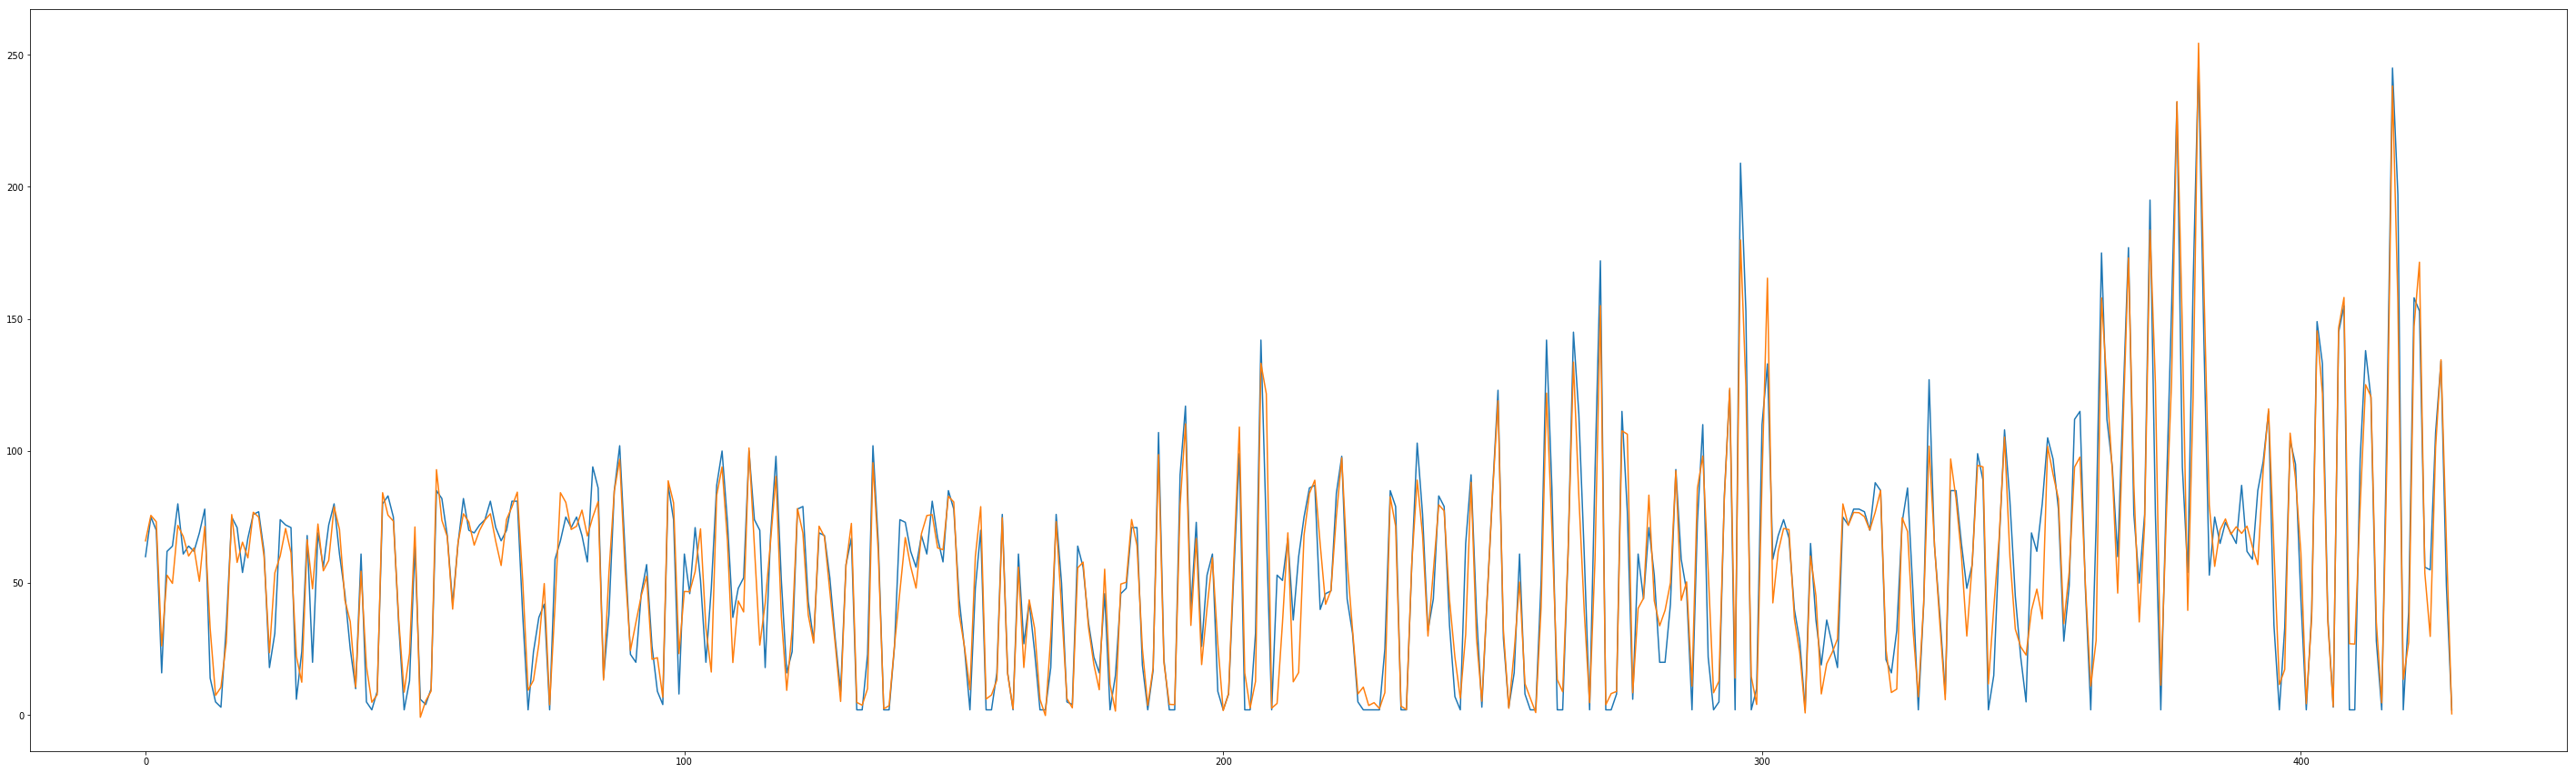

In [51]:
fig1 = plt.figure(figsize = (50,15))
ax = fig1.add_subplot(111)

sz = 2000
ax.plot(y_test[-sz:])
ax.plot(model.predict(X_test[-sz:]))
plt.show()

#### As can be seen from this grap model makes a close prediction